In [7]:
%pip install sewar

  Preparing metadata (setup.py) ... done
  Created wheel for sewar: filename=sewar-0.4.6-py3-none-any.whl size=11420 sha256=496a18043752dc0bd92b1ea3f7dfadca9a66c6e9494ba7eb22c5f2f00ae1079b
  Stored in directory: /root/.cache/pip/wheels/3f/af/02/9c6556ba287b62a945d737def09b8b8c35c9e1d82b9dfae84c
Successfully built sewar
Note: you may need to restart the kernel to use updated packages.


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import cv2
import rasterio
from torch.utils.data import Dataset
import math
from torch.nn import functional as F
import torchvision.models as models
import sewar

In [15]:
# Define the U-Net model
class DeeperUNet (nn.Module):
    def __init__(self):
        super(DeeperUNet, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1024, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Additional encoder layers
        self.additional_enc_layer1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Intermediate layers

        self.additional_enc_layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.additional_enc_layer3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.additional_enc_layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )


        self.middle = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )


        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 64, kernel_size=200, stride=200)
        )

        # Final convolution layer
        self.final_conv = nn.Conv2d(64, 4, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Reshape input vector to match image dimensions
        x = x.view(x.size(0), 1024, 6, 6)

        # Encoder
        enc_out = self.encoder(x)
 
        # Additional layers
        enc_out1 = self.additional_enc_layer1(enc_out)
        enc_out2 = self.additional_enc_layer2(enc_out1)
        enc_out3 = self.additional_enc_layer3(enc_out2)
        enc_out4 = self.additional_enc_layer4(enc_out3)

        # Intermediate
        middle_out = self.middle(enc_out4)


        # Decoder
        dec_out = self.decoder(middle_out)

        # Final convolution and sigmoid activation
        final_out = self.final_conv(dec_out)
        final_out = self.sigmoid(final_out)




        return final_out


# Hyperparameters
batch_size = 16
lr = 0.001

# Create U-Net model instance and move to GPU
model = DeeperUNet()
device = torch.device("cuda"torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('/kaggle/input/model-1/deepunetwithoutextractor.pth',map_location=torch.device('cpu')))

model.to(device)

RuntimeError: Error(s) in loading state_dict for DeeperUNet:
	Missing key(s) in state_dict: "decoder.4.weight", "decoder.4.bias". 
	size mismatch for encoder.0.weight: copying a param with shape torch.Size([64, 6, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 1024, 3, 3]).

In [ ]:
L_test = sio.loadmat("QB_test_256.mat")

In [ ]:
I_GT_test = L_test["I_GT"]
I_PAN_LR_test = L_test["I_PAN_LR"]
I_MS_test = L_test["I_MS_LR_UP"]

print("shape of test GT: {} MS :{} PAN:{}".format(I_GT_test.shape,I_MS_test.shape,I_PAN_LR_test.shape))
# Images have the same size and the same spatial resolution =)
###################################################################
I_GT_test = I_GT_test.transpose(1,2,0)
I_MS_test = I_MS_test.transpose(1,2,0)
I_PAN_LR_test = I_PAN_LR_test.transpose(1,2,0)

In [ ]:
def Convolution_op(Image, size, strides):
    """
    Divide image into subimages with a certain size and stride

    Parameters:
        Image (int): Image input.
        size (tuple) : size of the subimages equivalent to patch size in VIT
        strides (tuples) : the step in vertical and horizental

    Returns:
        int: The sum of the two input integers.
    """
    start_x = 0
    start_y = 0
    end_x = Image.shape[0] - size[0]
    end_y = Image.shape[1] - size[1]

    n_rows = (end_x//strides[0]) + 1
    n_columns = (end_y//strides[1]) + 1
    small_images = []
    for i in range(n_rows):
        for j in range(n_columns):
            new_start_x = start_x+i*strides[0]
            new_start_y= start_y+j*strides[1]
            small_images.append(Image[new_start_x:new_start_x+size[0],new_start_y:new_start_y+size[1],:])        
    small_images=np.asanyarray(small_images)  
    small_images = small_images.transpose(0,3,1,2)
    return small_images

size = (200,200) # size of images to change after according to vgg19
stride = (200,200) # we can change thi also it is the step

##########################################################
GT_test = Convolution_op(I_GT_test,size,stride) 
MS_test = Convolution_op(I_MS_test,size,stride) 
PAN_test =Convolution_op(I_PAN_LR_test,size,stride)

In [ ]:
def scaleMinMax(x):
    return((x - np.nanmin(x))/(np.nanmax(x) - np.nanmin(x)))
def scaleCCC(x):
    return((x - np.nanpercentile(x, 2))/(np.nanpercentile(x, 98) - np.nanpercentile(x,2)))
def scaleStd(x):
    return((x - (np.nanmean(x)-np.nanstd(x)*2))/((np.nanmean(x)+np.nanstd(x)*2) - (np.nanmean(x)-np.nanstd(x)*2)))
def showImageRGB(image):
    #format HxWxBands
    b, g, r, n = image[0,:],image[1,:],image[2,:],image[3,:]
    # you can use scaleStd or scaleMinMax and chose the best
    r = scaleCCC(r)  
    g = scaleCCC(g)        
    b = scaleCCC(b)   
    n = scaleCCC(n)        


        # Stack the bands into a 3D array
    image = np.stack((r, g, b), axis=2)
        
        # Normalize the image
        
        # Plot the image
    return image

In [10]:
def make_tuple(x):
    if isinstance(x, int):
        return x, x
    if isinstance(x, list) and len(x) == 1:
        return x[0], x[0]
    return x
class PatchSet(Dataset):

    def __init__(self, GT_data, MS_data , PAN_data):
        super(PatchSet, self).__init__()
        
        self.GT_data = GT_data
        self.MS_data = MS_data
        self.PAN_data = PAN_data

    def __len__(self):
        #number of total samples 
        return self.MS_data.shape[0]
    def __getitem__(self,idx):
        # processing for the ith subimages 
        I_GT =self.GT_data[idx]
        I_MS =self.MS_data[idx]
        I_PAN  = self.PAN_data[idx]
       
        I_GT = self.normalize(I_GT)
        I_MS = self.normalize(I_MS)
        I_PAN = self.normalize(I_PAN)
         
        I_GT = torch.from_numpy(I_GT).float() #image with blurring effect
        
        I_MS = torch.from_numpy(I_MS).float() 
 
        I_PAN =  torch.from_numpy(I_PAN).float() 
   
        return I_GT,I_MS,I_PAN #GT is reference, IPAN and MS are the inputs
    
    @staticmethod
    def normalize(data):
        # Normalize data
        data[data < 0] = 0
        data = data.astype('float32')
        data = data / 2048
        return data

In [11]:
#créé le DataLoader itérer sur les données de test pendant l'évaluation de votre modèle
test_dataset = PatchSet(GT_test,MS_test,PAN_test)
#############################################################
batch_size = 16
test_Loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, drop_last=False)

NameError: name 'GT_test' is not defined

In [6]:
# this is how we iterate the images on Pytorch
for (I_GT,I_MS,I_PAN) in test_Loader:
    break

NameError: name 'test_Loader' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'MS input image')

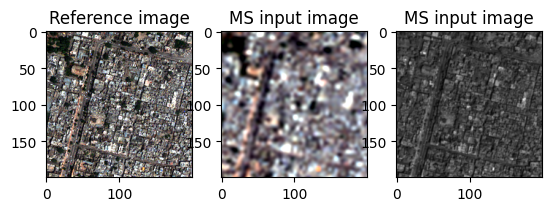

In [10]:
import matplotlib.pyplot as plt
plt.subplot(1,3,1)
plt.imshow(showImageRGB(I_GT.cpu().numpy()[2,:]))
plt.title("Reference image")
plt.subplot(1,3,2)
plt.imshow(showImageRGB(I_MS.cpu().numpy()[2,:]))
plt.title("MS input image")
plt.subplot(1,3,3)
plt.imshow((I_PAN.cpu().numpy()[2,0]),cmap="gray")
plt.title("MS input image")

In [11]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [12]:
batch_size = 16

In [15]:

model.eval()  # Set the model to evaluation mode
total_loss = 0.0
total_mse_loss = 0.0
total_psnr = 0.0
total_ssim = 0.0
total_batches = len(test_Loader)

with torch.no_grad():
    for batch_idx, (I_GT, I_MS, I_PAN) in enumerate(test_Loader):
        # Move data to GPU
        I_GT = I_GT.to(device)
        I_MS = I_MS.to(device)
        I_PAN = I_PAN.to(device)
        # Pass through VGG19 models to extract features
        features_rgb = I_MS[:, :3, :, :]  # Use only RGB channels

        # Extract Red (channel 0) and NIR (channel 3) from the I_MS tensor
        R = I_MS[:, 0:1, :, :]
        N = I_MS[:, 3:4, :, :]

        # Stack Red, NIR, and PAN (scaled) channels from I_PAN to form the combined RNP feature
        RNP = torch.cat([R, N, I_PAN], dim=1)

        features_rnp = RNP  # Pass the combined RNP feature through the model

        concatenated_features = torch.cat((features_rgb, features_rnp), dim=1)

        # Forward pass through the U-Net
        outputs = model(concatenated_features)
        print(outputs.shape)
        outputs = outputs.to(device)            
        # Calculate the loss and metrics
        loss = criterion(outputs, I_GT)
        mse_loss = F.mse_loss(outputs, I_GT, reduction='sum').item()

        total_loss += loss.item()
        total_mse_loss += mse_loss
    avg_loss = total_loss / total_batches
    avg_mse_loss = total_mse_loss / len(test_Loader.dataset)

    print(f'Average Test Loss: {avg_loss:.4f}, Average Test MSE Loss: {avg_mse_loss:.4f}')





torch.Size([12, 4, 200, 200])

Average Test Loss: 0.0026, Average Test MSE Loss: 408.4906


In [18]:
outputs = np.array(outputs.cpu().numpy())
I_GT = np.array(I_GT.cpu().numpy())
I_MS = np.array(I_MS.cpu().numpy())
I_PAN = np.array(I_PAN.cpu().numpy())

In [20]:
outputs = outputs.transpose(0,2,3,1)
I_GT2 = I_GT.transpose(0,2,3,1)
l=[]
# we calculate RMSE, SAM, SSIM and scc metrics check there is others in this library =)
for i in range(I_GT2.shape[0]):
        a=sewar.rmse(I_GT2[i,],outputs[i,]).round(4), sewar.sam(I_GT2[i,],outputs[i,]).round(4), sewar.ssim(I_GT2[i,],outputs[i,],MAX=1)[0].round(4), sewar.scc(I_GT2[i,],outputs[i,]).round(4)
        l.append([a])

In [21]:
metrics = np.array(l).round(4)

In [22]:
metrics.mean(axis=0)

array([[0.0504    , 0.22259167, 0.40483333, 0.00048333]])

In [24]:
outputs = outputs.transpose(0,3,2,1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 199.5, 199.5, -0.5)

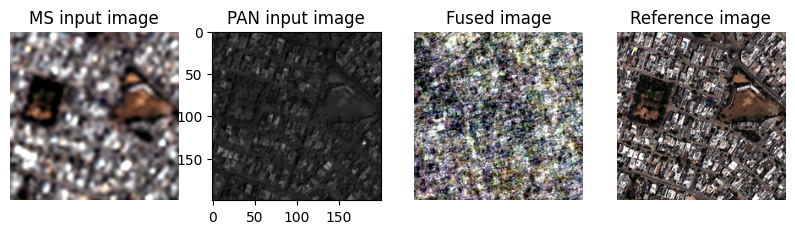

In [26]:
import matplotlib.pyplot as plt
# show image i
i=10
plt.figure(figsize=(10,6))
plt.subplot(1,4,1)
plt.imshow(showImageRGB(I_MS[i,:]))
plt.title("MS input image")
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow((I_PAN[i,0]),cmap="gray")
plt.title("PAN input image")
plt.subplot(1,4,3)
plt.axis('off')
plt.imshow(showImageRGB(outputs[i,]))
#plt.imshow(showImageRGB(ov))
plt.title("Fused image")
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(showImageRGB(I_GT[i,]))
plt.title("Reference image")
plt.axis('off')

In [ ]:
i=2
plt.figure(figsize=(10,6))
plt.subplot(1,4,1)
plt.imshow(showImageRGB(I_MS[i,:]))
plt.title("MS input image")
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow((I_PAN[i,0]),cmap="gray")
plt.title("PAN input image")
plt.subplot(1,4,3)
plt.axis('off')
plt.imshow(showImageRGB(outputs[i,]))
#plt.imshow(showImageRGB(ov))
plt.title("Fused image")
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(showImageRGB(I_GT[i,]))
plt.title("Reference image")
plt.axis('off')